In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from tqdm import tqdm
import pickle

The goal is to compile the data from the USTA 2017 top 50 players and encode this into datasets of probability of winning a point based off of elo and court surface.
This will be a simple logistic model where the elo term is the difference between the servers elo and returners elo.

In [64]:
rankings = pd.read_csv('Elo_Rankings2017.csv')
rankings.head()

,rank,name,country_name,country_id,points,bestRank,bestRankDate,rankDiff,pointsDiff,bestPoints
0,1,Roger Federer,Switzerland,SUI,2444,1,2003-08-11,0,0,2550
1,2,Novak Djokovic,Serbia,SRB,2418,1,2011-03-21,0,0,2629
2,3,Andy Murray,United Kingdom,GBR,2353,2,2009-04-19,0,0,2500
3,4,Rafael Nadal,Spain,ESP,2350,1,2008-06-16,0,0,2552
4,5,Juan Martin Del Potro,Argentina,ARG,2243,3,2010-06-07,0,0,2331


# Construct Dataframe

In [65]:
points_matrix = np.array([[0, 1, 2]])

tours = ['ausopen', 'frenchopen', 'usopen', 'wimbledon']

for year in tqdm(np.arange(2014, 2018)):
    for tour in tours:
        matches = pd.read_csv('tennis_data/' + str(year) + '-' + tour + '-matches.csv')
        points = pd.read_csv('tennis_data/' + str(year) + '-' + tour + '-points.csv')
        points = points[points.PointWinner != 0]
        points = points.reset_index()

        points_sub_matrix = np.zeros((np.shape(points)[0], 3))

        for i, point in points.iterrows(): #range(np.shape(points)[0]):
            p1 = matches.player1.values[matches.match_id == point.match_id][0] 
            p2 = matches.player2.values[matches.match_id == point.match_id][0]

            if ((p1 in (rankings.name.values)) == False) | ((p2 in (rankings.name.values)) == False):
                # We don't know one of the elo ratings of the players so we pass it off
                points_sub_matrix[i] = [np.nan, np.nan, np.nan]
                continue

            p1_elo = rankings.points[rankings.name == p1].values[0]
            p2_elo = rankings.points[rankings.name == p2].values[0]

            if tour == 'wimbledon':
                court = 1 #'grass'
            elif tour == 'frenchopen':
                court = 2 # 'clay'
            else:
                court = 3 # 'hard'

            winner = points.iloc[i].PointWinner

            # Determine who is serving
            # ***** Response is 0 if Server wins point, 1 if Returner wins point
            if point.PointServer == 1:
                if winner == point.PointServer:
                    points_sub_matrix[i] = [(p1_elo - p2_elo), court, 0]
                else:
                    points_sub_matrix[i] = [(p1_elo - p2_elo), court, 1]

            elif point.PointServer == 2:
                if winner == point.PointServer:
                    points_sub_matrix[i] = [(p2_elo - p1_elo), court, 0]
                else:
                    points_sub_matrix[i] = [(p2_elo - p1_elo), court, 1]


        points_matrix = np.append(points_matrix, points_sub_matrix, axis=0)


100%|██████████| 4/4 [07:49<00:00, 117.36s/it]


In [66]:
colnames = ['elo_diff', 'court', 'winner']
points_df = pd.DataFrame(points_matrix[1:], columns=colnames)
points_df = points_df.dropna()
points_df.to_csv('point_probs.csv')
points_df['court'] = points_df['court'].astype('category')
points_df['winner'] = points_df['winner'].astype('category')

points_df.head()

,elo_diff,court,winner
0,-474.0,3.0,0.0
1,-474.0,3.0,1.0
2,-474.0,3.0,0.0
3,-474.0,3.0,0.0
4,-474.0,3.0,1.0


# Train Logistic Model

In [94]:
X = points_df[['elo_diff', 'court']]
y = points_df['winner']

#poly = PolynomialFeatures(degree = 1, interaction_only=False, include_bias=False)
#X_poly = poly.fit_transform(X)

lm_points = LogisticRegression(random_state=143)
lm_points.fit(X, y)

LogisticRegression(random_state=143)

# Evaluate FIt

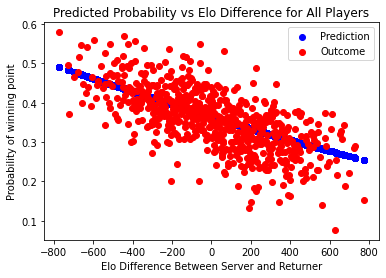

In [95]:
points_df_hardc = points_df[points_df.court == 3.0]
X = points_df_hardc[['elo_diff', 'court']]
y = points_df_hardc['winner']

#X_poly = poly.fit_transform(X)

preds = lm_points.predict_proba(X)[:,1]


elo_diffs_unique = np.unique(points_df_hardc.elo_diff.values)
bin_win_avg = []
for diff in elo_diffs_unique:
    subdf = points_df_hardc[points_df_hardc.elo_diff == diff]
    subdf = subdf.astype('int32')
    bin_win_avg.append(np.mean(subdf.winner))


plt.scatter(points_df_hardc.elo_diff, preds, color='blue', label = 'Prediction')
plt.scatter(elo_diffs_unique, bin_win_avg, color='red', label = 'Outcome')
plt.xlabel('Elo Difference Between Server and Returner')
plt.ylabel('Probability of winning point')
plt.title('Predicted Probability vs Elo Difference for All Players')
plt.legend()
plt.savefig('plots/general_model_check.png')

In [101]:
# Save model to be used in streaks script
#pickle.dump(lm_points, open('point_prob_model.sav', 'wb'))

lm_points = pickle.load(open('point_prob_model.sav', 'rb'))
lm_points.coef_

array([[-0.00066997,  0.05252886]])

# Test calibration with Federer

In [57]:

federer_matrix = np.array([[0, 1, 2]])

tours = ['ausopen', 'usopen']
player = 'Roger Federer'

for year in tqdm(np.arange(2014, 2018)):
    for tour in tours:
        matches = pd.read_csv('tennis_data/' + str(year) + '-' + tour + '-matches.csv')
        points = pd.read_csv('tennis_data/' + str(year) + '-' + tour + '-points.csv')
        points = points[points.PointWinner != 0]
        points = points.reset_index()

        points_sub_matrix = np.zeros((np.shape(points)[0], 3))

        for i, point in points.iterrows(): #range(np.shape(points)[0]):
            p1 = matches.player1.values[matches.match_id == point.match_id][0] 
            p2 = matches.player2.values[matches.match_id == point.match_id][0]

            if ((p1 in (rankings.name.values)) == False) | ((p2 in (rankings.name.values)) == False):
                # We don't know one of the elo ratings of the players so we pass it off
                points_sub_matrix[i] = [np.nan, np.nan, np.nan]
                continue

            if (p1 != player):
                continue

            p1_elo = rankings.points[rankings.name == p1].values[0]
            p2_elo = rankings.points[rankings.name == p2].values[0]

            if tour == 'wimbledon':
                court = 1 #'grass'
            elif tour == 'frenchopen':
                court = 2 # 'clay'
            else:
                court = 3 # 'hard'

            winner = points.iloc[i].PointWinner

            # Determine who is serving
            # ***** Response is 0 if Server wins point, 1 if Returner wins point
            if point.PointServer == 1:
                if winner == point.PointServer:
                    points_sub_matrix[i] = [(p1_elo - p2_elo), court, 0]
                else:
                    points_sub_matrix[i] = [(p1_elo - p2_elo), court, 1]


        federer_matrix = np.append(federer_matrix, points_sub_matrix, axis=0)

100%|██████████| 4/4 [02:19<00:00, 34.83s/it]


In [58]:
colnames = ['elo_diff', 'court', 'winner']
federer_df = pd.DataFrame(federer_matrix[1:], columns=colnames)
federer_df = federer_df.dropna()
federer_df.to_csv('point_probs.csv')
federer_df['court'] = federer_df['court'].astype('category')
# federer_df['winner'] = federer_df['winner'].astype('category')
federer_df = federer_df[(federer_df.elo_diff != 0)]

# federer_df.to_csv('federer_test_data.csv')
federer_df.head()

,elo_diff,court,winner
133008,597.0,3.0,0.0
133009,597.0,3.0,0.0
133010,597.0,3.0,0.0
133011,597.0,3.0,0.0
133018,597.0,3.0,0.0


In [97]:
federer_df = pd.read_csv('federer_test_data.csv')
# Bin the data
elo_diffs_unique = np.unique(federer_df.elo_diff.values)

# federer_df['winner'] = federer_df['winner'].astype('numeric')

bin_win_avg = []

for diff in elo_diffs_unique:
    subdf = federer_df[federer_df.elo_diff == diff]
    bin_win_avg.append(np.mean(subdf.winner))


federer_df['winner'] = federer_df['winner'].astype('category')

X_f = federer_df[['elo_diff', 'court']]
X_f_poly = poly.fit_transform(X_f)

preds = lm_points.predict_proba(X_f_poly)[:,1]


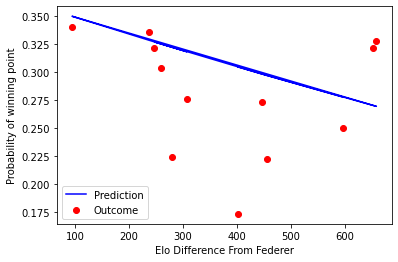

In [99]:
plt.plot(federer_df.elo_diff, preds, color='blue', label = 'Prediction')
plt.scatter(elo_diffs_unique, bin_win_avg, color='red', label = 'Outcome')
plt.xlabel('Elo Difference From Federer')
plt.ylabel('Probability of winning point')
plt.legend()
plt.savefig('plots/Federer_model_check.png')
